<a href="https://colab.research.google.com/github/shimamz71/9-TYPE-OF-CNN/blob/main/AE_CONV2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9912422/9912422 [00:00<00:00, 115893068.68it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104970271.94it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32101241.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6767505.78it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



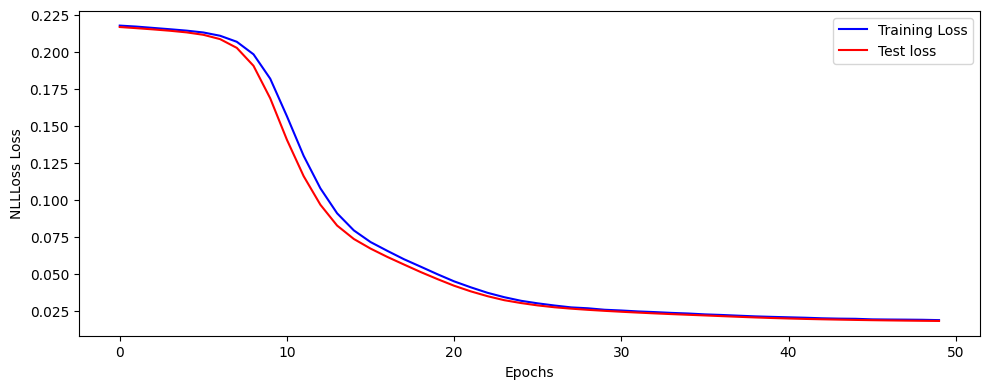

First row is the original images.
Second row is the reconstructed images.


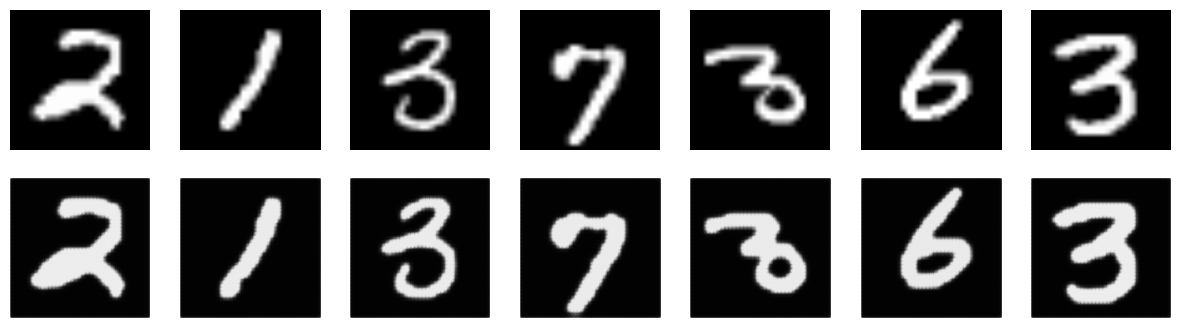

In [1]:
# Import the necessary libraries
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

# ensures reproducibility and avoids random initialization
torch.manual_seed(1)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Define the autoencoder model with four encoding layers and four decoding layers
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # The encoding layers consist of convolutional layers with ReLU activation and max pooling
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, stride=1), # Input: (N, 1, 600, 600), Output: (N, 8, 600, 600)
            nn.ReLU(),
            nn.MaxPool2d(2),    # Output: (N, 8, 300, 300)

            nn.Conv2d(8, 16, 3, padding=1,stride=1),   # Output: (N, 16, 300, 300)
            nn.ReLU(),
            nn.MaxPool2d(2),    # Output: (N, 16, 150, 150)

            nn.Conv2d(16, 32, 3, padding=1,stride=1),   # Output: (N, 32, 150 ,150)
            nn.ReLU(),
            nn.MaxPool2d(2),   # Output: (N ,64 ,75 ,75)

            nn.Conv2d(32, latent_dim, 4, padding=2,stride=1),   # Output: (N ,latent_dim ,76 ,76)
            nn.ReLU(),
            nn.MaxPool2d(2)    # Output: (N ,latent_dim ,38 ,38)
        )
        # The decoding layers consist of transposed convolutional layers with ReLU activation and upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 32, 3, padding=1, stride=2),  # Input: (N ,latent_dim ,38 ,38), Output: (N ,32 ,75 ,75)
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, 3, padding=1,stride=2),    # Output: (N ,16 ,149 ,149)
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, padding=0,stride=2),    # Output: (N ,8 ,299 ,299)
            nn.ReLU(),

            nn.ConvTranspose2d(8, 1, 4, padding=0,stride=2),   # Output: (N ,16 ,600 ,600)
            nn.Sigmoid()
        )

    def forward(self, x):
        # Pass the input through the encoder and decoder
        x = self.encoder(x)
        # print(x.shape)
        x = self.decoder(x)
        # print(x.shape)
        return x


# Define the transform to convert images to tensors, normalize them, and resize them
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert color images to grayscale
    transforms.Resize((600, 600), interpolation = Image.BILINEAR),  # Resize the images to 600 x 600 pixels (bilinear interpolation)
    transforms.ToTensor(),  # Convert PIL images to tensors of range [0, 1]
    ])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a subset of 500 samples
subset = torch.utils.data.Subset(dataset, range(500))
# Split the dataset into train and test sets with an 80-20 ratio
trainset, testset = torch.utils.data.random_split(subset, [400, 100])

# Create data loaders for batch processing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

reconstract_data = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=True) # Using for plot reconstract_images

device = 'cuda' if torch.cuda.is_available() else 'cpu'

latent_dim = 64
# Create an instance of the model
model = Autoencoder()
model = model.to(device)
# Define the loss function as mean squared error
loss_fn = nn.MSELoss()
# Define the optimizer as Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)
n_iters = 50

def AE_train(train,test,test_rec):
    test_loss = []
    train_loss = []
    for epoch in range(n_iters):
        batch_train_loss = []
        model.train()
        for (data, _) in train:
            label = data = data.to(device)
            optimizer.zero_grad() # the model will overshoot the minimum and oscillate around it
            y_predict = model(data)
            loss_train = loss_fn(y_predict, label)
            batch_train_loss.append(loss_train.item())
            loss_train.backward()
            optimizer.step()
        train_loss.append(np.mean(batch_train_loss))
        model.eval()
        for data_test, _ in test:
            label_test = data_test = data_test.to(device)
            y_test_predict = model(data_test)
            loss_test = loss_fn(y_test_predict, label_test)
            test_loss.append(loss_test.item())
    fig = plt.figure(figsize=(10, 4))
    plt.plot(train_loss, label='Training Loss', c='b')
    #.detach().cpu().numpy()
    plt.plot(test_loss, label='Test loss', c='r')
    # .detach().cpu().numpy()
    plt.xlabel('Epochs')
    plt.ylabel('NLLLoss Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


    for data,_ in test_rec:
        recon = model(data.to(device))
        break
    print("\033[93m" + f"First row is the original images." + "\033[0m")
    print("\033[93m" + f"Second row is the reconstructed images." + "\033[0m")
    fig, ax = plt.subplots(2, 7, figsize=(15, 4))  # Create a subplot with 2 rows and 7 columns
    for i in range(7):
        ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)), 'gray')
        ax[1, i].imshow(recon[i].detach().cpu().numpy().transpose((1, 2, 0)),'gray')
        ax[0, i].axis('OFF')
        ax[1, i].axis('OFF')  # Turn off the axis labels for both rows
    plt.show()

AE_train(trainloader,testloader,reconstract_data)


# sbs_autoencoder = StepByStep(model, loss_fn, optimizer)
# sbs_autoencoder.set_loaders(trainloader, testloader)
# sbs_autoencoder.train(50)
# sbs_autoencoder.plot_losses() # Plot MSE loss train and test
# plt.show()

# sbs_autoencoder.predict(reconstract_data)